<a id="GettingStarted"></a>
## 1. Getting Started

**<font style="color:red">If you are running the car in RacecarSim, set `isSimulation` to `True`</font>**. Leave `isSimulation` `False` if you are using a physical car.

In [79]:
# Import Python libraries
import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import statistics
from nptyping import NDArray
from typing import Any, Tuple, List, Optional

# Import Racecar library
import sys
sys.path.append("../../library")
import racecar_core
import racecar_utils as rc_utils

Finally, we will create a racecar object.  If this step fails, make sure that `isSimulation` has the correct value.

<a id="GatheringLidarData"></a>
## 2. Gathering LIDAR Data
The racecar's LIDAR data is stored as a one-dimensional numpy array of 720 distance measurements.  Each measurement is 1/2 of a degree apart, ordered clockwise, with the 0th entry directly in front of the car.

In Jupyter Notebook, we can access the car's LIDAR data using `rc.lidar.get_samples_async()`.  Outside of Jupyter Notebook, we must use `rc.lidar.get_samples()` instead.

In [82]:
# Calculate and show the forward and rear distances
forward_distance = scan[0]
print(f"Forward distance: {forward_distance:.2f} cm")

rear_distance = scan[360]
print(f"Rear distance: {rear_distance:.2f} cm")

Forward distance: 56.65 cm
Rear distance: 77.69 cm


**<span style="color:red">Set `left_distance` and `right_distance` in the following code block to the LIDAR measurements directly to the left and directly to the right of the car.</span>**

<a id="VisualizingLidarData"></a>
## 3. Visualizing LIDAR data

In this section, we will write a function to convert LIDAR data into a color image providing a top-down view of the data.  We will use the following approach:

1. Create an all-black BGR image (a 3D numpy array ordered rows, columns, color channels) of the specified radius.
1. Denote the car by drawing a green dot at the center of the image with [`rc_utils.draw_circle`](https://mitll-racecar.readthedocs.io/en/latest/racecar_utils.html#racecar_utils.draw_circle).
1. For each LIDAR sample, set the corresponding pixel to red. We can calculate the angle of each sample based on its index in the scan.  By scaling the distance such that `max_range` is the edge of the image, we can convert this angle and distance into a row and column in the image.
1. `highlighted_samples` contains a list of `(angle, distance)` measurements that we wish to highlight with light blue dots. These can be plotted similarly to the samples in the previous step and drawn with `rc_utils.draw_circle`.
1. Display the color image in the Jupyter Notebook with Matplotlib.

The result should look similar to the LIDAR visualization shown in the left sidebar of RacecarSim.

**<span style="color:red">Finish implementing this approach in the `show_lidar` function below.</span>**

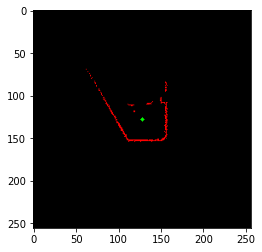

In [112]:
show_lidar(scan)

For now, we will test out the `highlighted_samples` feature by highlighting points 100 cm in each cardinal direction.

<a id="HandlingNoise"></a>
## 4. Handling Noise

Just like depth images, LIDAR data is also subject to noise and null values. To help combat this, we will once again average several neighboring samples across an *angle window* instead of relying on a single measurement. For example, if we want to measure the distance at 60 degrees with a 4 degree window angle, we would average all of the samples from 58 to 62 degrees.  To reduce the impact of null values, we should not consider any 0.0 measurement in our average.

**<span style="color:red">Implement this approach in `get_lidar_average_distance`</span>**. You may wish to use a Python [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions).

In [127]:
WINDOW_ANGLE = 6
rear_distance = get_lidar_average_distance(scan, 180, WINDOW_ANGLE)
print(f"Rear distance ({WINDOW_ANGLE} degree window): {rear_distance:.2f} cm")

Rear distance (6 degree window): 78.11 cm


`get_lidar_average_distance` must handle when the angle window passes over the edge of the array.  For example, with an angle of 0 and a window angle of 6, we must consider all samples in the range 357 to 3 degrees.

**<span style="color:red">If you have not done so already, update `get_lidar_average_distance` to support angle windows that cross the edge of the array.</span>**.

Finally, we must handle when there is no data in the specified angle window.  In this case, we should return `0.0`.

**<span style="color:red">If you have not done so already, update `get_lidar_average_distance` to return `0.0` when the specified range does not contain any data.</span>**.

In [171]:
def get_lidar_closest_point(
    scan: NDArray[Any, np.float32], window: Tuple[float, float] = (0, 360)
) -> Tuple[float, float]:
    """
    Finds the closest point from a LIDAR scan.

    Args:
        scan: The samples from a LIDAR scan.
        window: The degree range to consider, expressed as (min_degree, max_degree)

    Returns:
        The (angle, distance) of the point closest to the car within the specified
        degree window. All angles are in degrees, starting at 0 directly in front of the
        car and increasing clockwise. Distance is in cm.

    Note:
        Ignores any samples with a value of 0.0 (no data).

        In order to define a window which passes through the 360-0 degree boundary, it
        is acceptable for window min_degree to be larger than window max_degree.  For
        example, (350, 10) is a 20 degree window in front of the car.
    """
    # TODO: Return the (angle, distance) of the closest point within the specified window
    window *= 2
    window = (window[0] % 720, window[1] %720)
    scan_copy = scan[window[0] : window[1]] if window [1] > window[0] else np.append(scan[window[0] :720], scan[0 : window[1]])
    scan_copy = (scan_copy - 0.01) % 10000
    min_ind = np.argmin(scan_copy)
    return ((min_ind/2 + window[0]/2) % 360, scan_copy[min_ind])

Let's use `get_lidar_closest_point` to find the closest point to the right of the car.

Once again, we should handle when the specified degree range passes over the edge of our array.  **<span style="color:red">If you have not done so already, update `get_lidar_closest_point` to support negative angles and windows that cross the edge of the array.</span>**.